# Inicio

Esta propuesta hace uso del modelo Poisson para analizar la optimización del feature engineering. El modelo se alimenta de información sobre partidos, pero con el añadido de un embedding de los equipos para darle más información. Además estos embeddings son ideales para usarse en otros modelos o hacer clustering. Además el modelo Poisson permite analizar bastante bien el impacto de cada variable. Las métricas que se recogerán son:
<li> Jugadores
<li> Países
<li> Equipos
<li> Formaciones</li>
<br>
Están disponibles en embeddings/ en formato csv

In [1]:
import pandas as pd

data_path = '../Data/'

df_clubs = pd.read_csv(data_path + 'clubs.csv')

# Carga Matches.csv en df_matches
df_games = pd.read_csv(data_path + 'games.csv', date_format='%Y-%m-%d', parse_dates=['date'])

# Carga informacion
df_players = pd.read_csv(data_path + 'players.csv')
df_lineups = pd.read_csv(data_path + 'game_lineups.csv')
df_competitions = pd.read_csv(data_path + 'competitions.csv')
df_appearances = pd.read_csv(data_path + 'appearances.csv')
df_game_lineups = pd.read_csv(data_path + 'game_lineups.csv')
df_game_events = pd.read_csv(data_path + 'game_events.csv')
df_player_valuations = pd.read_csv(data_path + 'player_valuations.csv', date_format='%Y-%m-%d', parse_dates=['date'])
df_transfers = pd.read_csv(data_path + 'transfers.csv')
df_competitions = pd.read_csv(data_path + 'competitions.csv')

# Limpieza de las competiciones

El objetivo es estandarizar los tipos de competiciones y sus distintas fases para así poder analizar métricas como lo lejos que ha avanzado un equipo en un torneo.

## Visualizar rondas de competiciones

In [2]:
pd.set_option('display.max_colwidth', None)

In [3]:
df_competitions.head()

,competition_id,competition_code,name,sub_type,type,country_id,country_name,domestic_league_code,confederation,is_major_national_league
0,CIT,italy-cup,italy-cup,domestic_cup,domestic_cup,75,Italy,IT1,europa,False
1,NLSC,johan-cruijff-schaal,johan-cruijff-schaal,domestic_super_cup,other,122,Netherlands,NL1,europa,False
2,GRP,kypello-elladas,kypello-elladas,domestic_cup,domestic_cup,56,Greece,GR1,europa,False
3,POSU,supertaca-candido-de-oliveira,supertaca-candido-de-oliveira,domestic_super_cup,other,136,Portugal,PO1,europa,False
4,RUSS,russian-super-cup,russian-super-cup,domestic_super_cup,other,141,Russia,RU1,europa,False


In [4]:
df_competitions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44 entries, 0 to 43
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   competition_id            44 non-null     object
 1   competition_code          44 non-null     object
 2   name                      44 non-null     object
 3   sub_type                  44 non-null     object
 4   type                      44 non-null     object
 5   country_id                44 non-null     int64 
 6   country_name              44 non-null     object
 7   domestic_league_code      44 non-null     object
 8   confederation             44 non-null     object
 9   is_major_national_league  44 non-null     bool  
dtypes: bool(1), int64(1), object(8)
memory usage: 3.3+ KB


In [5]:
df_competitions.nunique()

competition_id              44
competition_code            43
name                        43
sub_type                    12
type                         4
country_id                  15
country_name                15
domestic_league_code        15
confederation                1
is_major_national_league     2
dtype: int64

In [6]:
df_games.head(1)

,game_id,competition_id,season,round,date,home_club_id,away_club_id,home_club_goals,away_club_goals,home_club_position,away_club_position,home_club_manager_name,away_club_manager_name,stadium,attendance,referee,home_club_formation,away_club_formation,competition_type
0,2321027,L1,2013,1. Matchday,2013-08-11,33,41,3,3,8,9,Jens Keller,Thorsten Fink,Veltins-Arena,61973,Manuel Gräfe,4-2-3-1,4-2-3-1,domestic_league


In [7]:
df_competitions['type'].unique()

array(['domestic_cup', 'other', 'international_cup', 'domestic_league'],
      dtype=object)

In [8]:
df_competitions.groupby('type')['sub_type'].unique()

type
domestic_cup                                                                                                                                                                                      [domestic_cup]
domestic_league                                                                                                                                                                                     [first_tier]
international_cup    [uefa_super_cup, europa_league, uefa_europa_conference_league, europa_league_qualifying, uefa_europa_conference_league_qualifiers, uefa_champions_league, uefa_champions_league_qualifying]
other                                                                                                                                                      [domestic_super_cup, league_cup, fifa_club_world_cup]
Name: sub_type, dtype: object

In [9]:
df_games['round'].unique()

array(['1. Matchday', '2. Matchday', '3. Matchday', '5. Matchday',
       '6. Matchday', '11. Matchday', '17. Matchday', '20. Matchday',
       '29. Matchday', '31. Matchday', '32. Matchday', '18. Matchday',
       '8. Matchday', '10. Matchday', '15. Matchday', '19. Matchday',
       '22. Matchday', '21. Matchday', '24. Matchday', '28. Matchday',
       '34. Matchday', '36. Matchday', '14. Matchday', '13. Matchday',
       '23. Matchday', '37. Matchday', '35. Matchday', '9. Matchday',
       '26. Matchday', '25. Matchday', '30. Matchday', '4. Matchday',
       '12. Matchday', '7. Matchday', '33. Matchday', '27. Matchday',
       'Group B', 'Group F', 'Group E', 'Third Round', 'Group H',
       'Group C', '4th round 2nd leg', 'last 16 1st leg',
       'Semi-Finals 1st Leg', 'Fifth Round', 'Quarter-Finals 1st leg',
       'Semi-Finals', '16. Matchday', '3rd round 2nd leg',
       'Qualifying Round 2nd leg', 'group L', 'Group D',
       'First Round 1st leg', 'Quarter-Finals 2nd leg', 'Qu

Podemos ver que hay sufijos como 'deciders', 'replay', '1st leg', '2nd leg'. Además el uso de mayúsculas y minúsculas no es consistente y a veces se escriben las rondas como 'first' y otras como '1st'

## Estandarización de las rondas de los partidos

In [10]:
import re

# Hacemos que todo esté escrito en minúscula para estandarizar las rondas
df_games['round'] = df_games['round'].str.lower().str.strip()

# Sustituímos las rondas escritas como palabra a números para crear un formato uniforme
df_games['round'] = df_games['round'].str.replace(
    r'\bfirst\b', '1st', flags=re.IGNORECASE, regex=True
).str.replace(
    r'\bsecond\b', '2nd', flags=re.IGNORECASE, regex=True
).str.replace(
    r'\bthird\b', '3rd', flags=re.IGNORECASE, regex=True
).str.replace(
    r'\bfourth\b', '4th', flags=re.IGNORECASE, regex=True
).str.replace(
    r'\bfifth\b', '5th', flags=re.IGNORECASE, regex=True
).str.replace(
    r'\bsixth\b', '6th', flags=re.IGNORECASE, regex=True
).str.replace(
    r'\bseventh\b', '7th', flags=re.IGNORECASE, regex=True
).str.replace(
    r'\beightth\b', '8th', flags=re.IGNORECASE, regex=True
)

# Creamos una columna para saber las posibles características adicionales que pueda tener la ronda, como que sea un desempate (replay)
df_games['round_suffix'] = df_games['round'].str.extract(
    r'\b(deciders|replay|1st leg|2nd leg)\b', flags=re.IGNORECASE
)

# Eliminamos las características de la ronda que ya hemos trasladado a otra columna
df_games['round_type'] = df_games['round'].str.replace(
    r'\b(deciders|replay|1st leg|2nd leg)\b', '', flags=re.IGNORECASE, regex=True
).str.strip().str.replace(r'\s{2,}', ' ', regex=True)

df_games.loc[df_games['round'].str.contains('matchday') == True, 'round_type'] = 'matchday'
df_games.loc[df_games['round'].str.contains('group') == True, 'round_type'] = 'group'

# Las rondas que no contengan un mínimo de caracteres y letras probablemente son registros mal imputados así que lo llenamos con 'desconocido'
df_games['round'] = df_games['round'].mask(df_games['round'].str.match(r"^(?!.*[a-zA-Z]).{1,2}$", na=False), 'desconocido')


# Creamos una columna para añadir características comunes a cualquier tipo de ronda
df_games['round_suffix'] = df_games['round'].str.extract(
    r'\b(decider[s]?|replay|1st leg|2nd leg)\b', flags=re.IGNORECASE
)

# Eliminamos del tipo de ronda el adjetivo que ya recojemos en sufijos
df_games['round_type'] = df_games['round'].str.replace(
    r'\b(decider[s]?|replay|1st leg|2nd leg)\b', '', flags=re.IGNORECASE, regex=True
).str.strip().str.replace(r'\s{2,}', ' ', regex=True)

# Agrupamos todas las rondas que en el nombre contengan matchday o group porque referencia a la misma fase de la competición y pueden tener variantes
df_games.loc[df_games['round'].str.contains('matchday') == True, 'round_type'] = 'matchday'
df_games.loc[df_games['round'].str.contains('group') == True, 'round_type'] = 'group'

df_games['round_type'].unique()

array(['matchday', 'group', '3rd round', '4th round', 'last 16',
       'semi-finals', '5th round', 'quarter-finals', 'qualifying round',
       '1st round', 'intermediate stage', '2nd round', 'round of 16',
       '6th round', 'final', '2.vorrunde', '1st preliminary round',
       'desconocido', 'qualification round', '3rd place play-off',
       '5th place match'], dtype=object)

Ahora que tenemos agrupados los tipos de ronda, pueden fácilmente ordenarse según la fecha en la que se han celebrado esas rondas. Hay que tener en cuenta que no tiene sentido tratar de calcular el avance de la competición para los valores matchday y desconocido. Con esta información calcularemos en qué fase del torneo se celebra cada partido

In [11]:
import numpy as np

# Crear columna competition_phase inicializada en None
df_games['competition_phase'] = None

# Excluir tipos no válidos para el cálculo de fase
exclude_rounds = ['matchday', 'desconocido']

# Filtrar solo los juegos válidos
mask_valid = ~df_games['round_type'].str.lower().isin(exclude_rounds)

# Agrupar por competición y temporada
for (comp_id, season), group in df_games[mask_valid].groupby(['competition_id', 'season']):
    
    # Obtener el orden cronológico de aparición de las rondas
    sorted_rounds = (
        group.sort_values('date')
        .drop_duplicates('round_type', keep='first')
        .round_type
        .tolist()
    )
    
    # Crear un diccionario con fase normalizada entre 0 y 1
    phase_dict = {
        round_name: i / (len(sorted_rounds) - 1) if len(sorted_rounds) > 1 else 0
        for i, round_name in enumerate(sorted_rounds)
    }
    
    # Asignar valores al DataFrame original
    mask_group = (df_games['competition_id'] == comp_id) & (df_games['season'] == season)
    df_games.loc[mask_group, 'competition_phase'] = df_games.loc[mask_group, 'round_type'].map(phase_dict)

# Asegurar tipo float
df_games['competition_phase'] = df_games['competition_phase'].astype(float)

df_games

,game_id,competition_id,season,round,date,home_club_id,away_club_id,home_club_goals,away_club_goals,home_club_position,...,away_club_manager_name,stadium,attendance,referee,home_club_formation,away_club_formation,competition_type,round_suffix,round_type,competition_phase
0,2321027,L1,2013,1. matchday,2013-08-11,33,41,3,3,8,...,Thorsten Fink,Veltins-Arena,61973,Manuel Gräfe,4-2-3-1,4-2-3-1,domestic_league,NaN,matchday,NaN
1,2321033,L1,2013,1. matchday,2013-08-10,23,86,0,1,13,...,Robin Dutt,EINTRACHT-Stadion,23000,Deniz Aytekin,4-3-2-1,4-3-1-2,domestic_league,NaN,matchday,NaN
2,2321044,L1,2013,2. matchday,2013-08-18,16,23,2,1,1,...,Torsten Lieberknecht,SIGNAL IDUNA PARK,80200,Peter Sippel,4-2-3-1,4-3-2-1,domestic_league,NaN,matchday,NaN
3,2321060,L1,2013,3. matchday,2013-08-25,23,24,0,2,18,...,Armin Veh,EINTRACHT-Stadion,23325,Wolfgang Stark,4-3-2-1,4-2-3-1,domestic_league,NaN,matchday,NaN
4,2321072,L1,2013,5. matchday,2013-09-14,16,41,6,2,1,...,Thorsten Fink,SIGNAL IDUNA PARK,80645,Tobias Welz,4-2-3-1,3-5-2,domestic_league,NaN,matchday,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78483,4399060,CLQ,2024,2nd round 1st leg,2024-07-24,1091,3900,3,2,Sin Ranking,...,Mladen Zizovic,Toumba Stadium,16135,David Smajc,4-2-3-1,4-2-3-1,international_cup,1st leg,2nd round,0.333333
78484,2382258,CDR,2013,4th round 2nd leg,2013-12-18,681,3705,4,0,Sin Ranking,...,Manolo Sanlúcar,Anoeta,17078,César Muñiz Fernández,4-2-3-1,4-2-4,domestic_cup,2nd leg,4th round,0.428571
78485,4233201,SFA,2023,4th round,2024-01-20,987,3020,3,1,Sin Ranking,...,Andy Graham,Fir Park,4119,John Beaton,5-3-2,4-2-3-1,domestic_cup,NaN,4th round,0.555556
78486,2469213,ELQ,2014,2nd round 1st leg,2014-07-17,987,21875,2,2,Sin Ranking,...,Rúnar Páll Sigmundsson,Fir Park,6700,Michael Johansen,4-5-1,4-3-3,international_cup,1st leg,2nd round,0.333333


# Métricas de países

Recabaremos estadísticas relativas a los países para usarlo es posteriores cálculos. No interesa un análisis detallado por país para el caso de uso, así que por simplicidad no se usarán técnicas de machine learning para codificarlo. Los datos que se guardarán son:
id,season,country_id,country_mean_phase,country_final_phase_wins,country_international_win_ratio
<li>id_country_season</li>
<li>country_id</li>
<li>season</li>
<li>country_mean_phase</li>
<li>ccountry_final_phase_wins</li>
<li>country_international_win_ratio</li>

In [12]:
# Descubrimos a qué país pertenece cada club en función del país al que pertencen las competiciones nacionales en las que participan

df_clubs = df_clubs.merge(
    df_competitions[['competition_id', 'country_id']],
    left_on='domestic_competition_id',
    right_on='competition_id',
    how='left'
).drop('competition_id', axis='columns')

In [13]:
df_clubs.head(1)

,domestic_competition_id,club_id,club_code,name,squad_size,average_age,foreigners_number,foreigners_percentage,national_team_players,stadium_name,stadium_seats,net_transfer_record,last_season,country_id
0,L1,105,sv-darmstadt-98,SV Darmstadt 98,27,25.6,13,48.1,1,Merck-Stadion am Böllenfalltor,17810,+€3.05m,2023,40


In [14]:
# Añadimos las columnas de pais de equipo local y visitante en los partidos

df_games = df_games.merge(
    df_clubs[['club_id', 'country_id']],
    left_on='home_club_id',
    right_on='club_id',
    how='left'
).drop('club_id', axis='columns').rename(columns={'country_id': 'home_country_id'})

df_games = df_games.merge(
    df_clubs[['club_id', 'country_id']],
    left_on='away_club_id',
    right_on='club_id',
    how='left'
).drop('club_id', axis='columns').rename(columns={'country_id': 'away_country_id'})

<b> Cálculo de country_mean_phase

In [15]:
df_country_games = df_games.copy()

# Primero obtenemos todos los partidos en los que los equipos del país hayan participado

home_phase = df_country_games[['season', 'home_country_id', 'competition_phase']].rename(
    columns={'home_country_id': 'country_id'}
)
away_phase = df_country_games[['season', 'away_country_id', 'competition_phase']].rename(
    columns={'away_country_id': 'country_id'}
)

#Se juntan los datos de las rondas que ha alcanzado tanto jugando local como visitante
all_phases = pd.concat([home_phase, away_phase], ignore_index=True)

# Calculamos lo lejos en el torneo que llegan los equipos del país
df_country_phase_stats = all_phases.groupby(['season', 'country_id']).agg(
    country_mean_phase=('competition_phase', 'mean')
).reset_index()

<b> Cálculo de ccountry_final_phase_wins

In [16]:
# Primero, obtenemos partidos de fase final
df_final_phase = df_country_games[df_country_games['competition_phase'] == 1].copy() # Como las fases están normalizadas el 1 siempre es la final

# Identificamos ganadores
df_final_phase['winner_country_id'] = df_final_phase.apply(
    lambda row: row['home_country_id'] if row['home_club_goals'] > row['away_club_goals']
    else row['away_country_id'] if row['away_club_goals'] > row['home_club_goals']
    else None, axis=1
)

# Filtramos partidos con ganador
df_final_phase = df_final_phase[df_final_phase['winner_country_id'].notna()]

# Agrupamos por temporada y país
df_final_wins = df_final_phase.groupby(['season', 'winner_country_id']).size().reset_index(name='country_final_phase_wins')

# Renombramos columna para unir con el resto
df_final_wins = df_final_wins.rename(columns={'winner_country_id': 'country_id'})

<b> Cálculo de country_international_win_ratio

In [17]:
# Unimos por temporada y país
df_country_stats = df_country_phase_stats.merge(
    df_final_wins, on=['season', 'country_id'], how='left'
)

# Rellenamos los países sin victorias en fase final con 0
df_country_stats['country_final_phase_wins'] = df_country_stats['country_final_phase_wins'].fillna(0).astype(int)

df_intl = df_country_games[df_country_games['competition_type'] == 'international_cup'].copy()

# Como local
home_stats = df_intl.groupby(['season', 'home_country_id']).agg(
    home_played=('home_club_goals', 'count'),
    home_wins=('home_club_goals', lambda x: (df_intl.loc[x.index, 'home_club_goals'] > df_intl.loc[x.index, 'away_club_goals']).sum())
).reset_index().rename(columns={'home_country_id': 'country_id'})

# Como visitante
away_stats = df_intl.groupby(['season', 'away_country_id']).agg(
    away_played=('away_club_goals', 'count'),
    away_wins=('away_club_goals', lambda x: (df_intl.loc[x.index, 'away_club_goals'] > df_intl.loc[x.index, 'home_club_goals']).sum())
).reset_index().rename(columns={'away_country_id': 'country_id'})

# Unimos local y visitante
country_wins = pd.merge(home_stats, away_stats, on=['season', 'country_id'], how='outer').fillna(0)

# Sumar totales
country_wins['total_played'] = country_wins['home_played'] + country_wins['away_played']
country_wins['total_wins'] = country_wins['home_wins'] + country_wins['away_wins']

# Calcular ratio
country_wins['country_international_win_ratio'] = country_wins['total_wins'] / country_wins['total_played']

df_country_stats = df_country_stats.merge(
    country_wins[['season', 'country_id', 'country_international_win_ratio']],
    on=['season', 'country_id'],
    how='left'
)

# Si algún país no jugó internacional, el ratio es 0
df_country_stats['country_international_win_ratio'] = df_country_stats['country_international_win_ratio'].fillna(0)

df_country_stats['id'] = df_country_stats['season'].astype(str) + '_' + df_country_stats['country_id'].astype(int).astype(str)

# Reordenar columnas si quieres que 'id' sea la primera
cols = ['id'] + [col for col in df_country_stats.columns if col != 'id']
df_country_stats = df_country_stats[cols]

df_country_stats.head()

,id,season,country_id,country_mean_phase,country_final_phase_wins,country_international_win_ratio
0,2012_19,2012,19.0,0.351220,5,0.410256
1,2012_39,2012,39.0,0.435681,3,0.250000
2,2012_40,2012,40.0,0.243640,6,0.500000
3,2012_50,2012,50.0,0.186310,3,0.407407
4,2012_56,2012,56.0,0.428186,2,0.344828


<b> Guardado de métricas de los países

In [18]:
df_country_stats.to_csv('embeddings/country_features.csv', index=False)

# Formaciones

Creamos embeddings de las formaciones. El motivo es que si se trataran como variables categóricas podrían perserse matices como el número de jugadores en cada línea

In [19]:
# Extraer formaciones únicas de home y away, unirlas y obtener únicas
home_formations = df_games['home_club_formation'].dropna().unique()
away_formations = df_games['away_club_formation'].dropna().unique()

# Unir y obtener el conjunto único
total_formations = pd.unique(pd.concat([
    pd.Series(home_formations),
    pd.Series(away_formations)
]))

# Convertir a lista si quieres
unique_formations_list = total_formations.tolist()
print(unique_formations_list)

['4-2-3-1', '4-3-2-1', '4-4-26', '4-3-3', '4-5-1', '4-1-4-1', '4-3-1-2', '3-5-2', '4-4-2', '5-4-1', '4-4-1-1', '3-4-2-1', '5-2-3', '4-1-3-2', '5-3-2', '3-6-1', '3-4-3', 'Unknown', '3-1-4-2', '2-5-3', '3-4-1-2', '2-6-2', '4-2-4', '3-3-3-1', '6-3-1', '5-1-4', '1-6-3', '3-3-4', '6-1-3', '4-1-5', '2-3-5', '2-4-4', '1-9-0', '4-6-0', '5-5-0', '6-2-2', '7-1-2', '3-2-5', '2-7-1', '1-7-2', '7-2-1', '7-3-0', '2-2-6', '3-7-0', '0-10-0', '3-1-6', '2-8-0', '6-4-0', '0-7-3', '1-5-4', '6-0-4', '1-4-5']


In [20]:
df_games['home_club_formation'].value_counts()

home_club_formation
4-2-3-1    22548
4-3-3      15522
Unknown     7332
4-4-26      6696
3-5-2       4866
4-1-4-1     4066
4-4-2       3732
3-4-2-1     2755
3-4-3       2372
4-3-1-2     1560
3-4-1-2     1359
5-3-2       1316
5-4-1       1295
4-4-1-1     1174
4-5-1        587
4-3-2-1      306
3-1-4-2      281
4-1-3-2      221
4-2-4        118
5-2-3         82
3-3-4         52
3-6-1         33
6-3-1         23
6-2-2         21
2-6-2         21
5-1-4         21
3-3-3-1       19
2-4-4         18
6-1-3         16
2-5-3         14
4-1-5         10
3-2-5          9
2-7-1          8
4-6-0          8
7-1-2          5
5-5-0          4
0-10-0         3
2-2-6          3
1-6-3          3
1-7-2          2
2-3-5          2
7-2-1          1
7-3-0          1
1-9-0          1
3-7-0          1
3-1-6          1
Name: count, dtype: int64

In [21]:
print(total_formations.size)

52


Observamos que el número de posibles formaciones es pequeño y la mitad de ellas apenas son usadas. Por ello usaramos un modelo simple para el embedding que evite el sobreajuste

In [22]:
def parse_formation(f):
    '''
    Convierte una cadena que representa la formación táctica de un equipo de fútbol en una lista numérica con características clave.

    Parámetros:
    -----------
    f : str
        Cadena con la formación táctica en formato típico, por ejemplo "4-4-2", "3-5-2", o "Unknown" si la formación no está disponible.

    Retorna:
    --------
    list[int]
        Lista con cuatro elementos enteros:
        - Número de defensas (primer número en la formación).
        - Número de mediocampistas (suma de todos los números excepto el primero y el último).
        - Número de delanteros (último número en la formación).
        - Número de líneas o segmentos en la formación (cantidad de números en la formación).

        Si la formación es 'Unknown' o la suma de jugadores supera 10 (formación inválida), devuelve [0, 0, 0, 0].
    '''

    if f == 'Unknown':
        return [0, 0, 0, 0]
    parts = list(map(int, f.split('-')))
    if sum(parts) > 10:
        return [0, 0, 0, 0] # Si se introducen más jugadores de los permitidos por error
    def_ = parts[0]
    att_ = parts[-1]
    mid_ = sum(parts[1:-1]) if len(parts) > 2 else 0
    lines_ = len(parts)
    return [def_, mid_, att_, lines_]

In [23]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,          # número de epochs sin mejora antes de detener
    restore_best_weights=True
)

X = np.array([parse_formation(f) for f in unique_formations_list], dtype=np.float32)

# Normalizar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Modelo embedding
input_form = Input(shape=(4,), name='formation_params') 
x = layers.Dense(16, activation='relu')(input_form) # Añade no linealidad
x = layers.Dense(8, activation='relu')(x) # Condensa la información
embedding = layers.Dense(4, activation='linear', name='formation_embedding')(x)  # salida de 4 dimensiones
model = Model(inputs=input_form, outputs=embedding)

model.compile(optimizer='adam', loss='mse')
model.fit(X_scaled, X_scaled, epochs=100, batch_size=16, callbacks=early_stop)

2025-06-16 06:56:07.741085: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-16 06:56:07.764864: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-16 06:56:07.764898: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-16 06:56:07.766203: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-16 06:56:07.772335: I tensorflow/core/platform/cpu_feature_guar

Epoch 1/100


2025-06-16 06:56:08.909917: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: UNKNOWN ERROR (100)


4/4 [==============================] - 0s 3ms/step - loss: 1.1976
Epoch 2/100
4/4 [==============================] - 0s 2ms/step - loss: 1.1665
Epoch 3/100
4/4 [==============================] - 0s 1ms/step - loss: 1.1369
Epoch 4/100
4/4 [==============================] - 0s 1ms/step - loss: 1.1089
Epoch 5/100
4/4 [==============================] - 0s 1ms/step - loss: 1.0854
Epoch 6/100
4/4 [==============================] - 0s 1ms/step - loss: 1.0632
Epoch 7/100
4/4 [==============================] - 0s 1ms/step - loss: 1.0416
Epoch 8/100
4/4 [==============================] - 0s 2ms/step - loss: 1.0207
Epoch 9/100
4/4 [==============================] - 0s 1ms/step - loss: 1.0029
Epoch 10/100
4/4 [==============================] - 0s 1ms/step - loss: 0.9849
Epoch 11/100
4/4 [==============================] - 0s 1ms/step - loss: 0.9693
Epoch 12/100
4/4 [==============================] - 0s 1ms/step - loss: 0.9536
Epoch 13/100
4/4 [==============================] - 0s 1ms/step - loss: 0

In [24]:
# Generar embeddings
embeddings = model.predict(X_scaled)

# Crear DataFrame con embeddings
df_emb = pd.DataFrame(embeddings, columns=[f'formation_emb_{i}' for i in range(embeddings.shape[1])])
df_emb['formation'] = unique_formations_list

# Reordenar columnas para que 'formation' para que el embedding quede al final
cols = ['formation'] + [f'formation_emb_{i}' for i in range(embeddings.shape[1])]
df_emb = df_emb[cols]

# Guardar a CSV
df_emb.to_csv('embeddings/formation_embeddings.csv', index=False)

print("Embeddings guardados en 'embeddings/formation_embeddings.csv'")


2/2 [==============================] - 0s 2ms/step
Embeddings guardados en 'embeddings/formation_embeddings.csv'


# Equipos

Queremos generar un embedding para cada equipo. Los datos que recogeremos son:
<li>domestic_cup_reached_phase</li>
<li>domestic_cup_titles</li>
<li>national_win_rate</li>
<li>international_win_rate</li>
<li>international_league_reached_phase</li>
<li>international_league_titles</li>
<li>formation_most_used</li>
<li>country_international_average_reached_phase</li>
<li>country_international_titles</li>
<li>country_international_victory_rate</li>
<li>has_played_international</li>
<li>avg_goals_scored_per_match</li>
<li>avg_goals_conceded_per_match</li>
<li>clean_sheets_rate</li>
<li>avg_goal_difference</li>

## Tasa victorias internacionales

In [25]:
df_international = df_games[df_games['competition_type'] == 'international_cup'].copy()

In [26]:
# Paso 1: Obtener todos los clubes y temporadas de df_games
clubs_seasons = pd.concat([
    df_games[['season', 'home_club_id']].rename(columns={'home_club_id': 'club_id'}),
    df_games[['season', 'away_club_id']].rename(columns={'away_club_id': 'club_id'})
]).drop_duplicates()

# Paso 2: Calcular partidos totales jugados (nacional + internacional)
df_home = df_games[['season', 'home_club_id']].rename(columns={'home_club_id': 'club_id'})
df_away = df_games[['season', 'away_club_id']].rename(columns={'away_club_id': 'club_id'})
df_all_matches = pd.concat([df_home, df_away])
df_all_matches['match_count'] = 1

df_total_matches = df_all_matches.groupby(['season', 'club_id'])['match_count'].sum().reset_index()

# Paso 3: Calcular victorias internacionales, como ya haces, pero para todos los clubes se rellena 0 si no tienen
df_international = df_games[df_games['competition_type'] == 'international_cup'].copy()

def get_winner(row):
    if row['home_club_goals'] > row['away_club_goals']:
        return row['home_club_id']
    elif row['home_club_goals'] < row['away_club_goals']:
        return row['away_club_id']
    else:
        return None

df_international['winner_id'] = df_international.apply(get_winner, axis=1)
df_victories = df_international[['season', 'winner_id']].dropna().copy()
df_victories['victory_count'] = 1 # Añade una victoria a los equipos ganadores
df_victories = df_victories.groupby(['season', 'winner_id'])['victory_count'].sum().reset_index()
df_victories = df_victories.rename(columns={'winner_id': 'club_id'})

# Paso 4: Merge para obtener ratio victorias internacionales
df_win_ratio = pd.merge(df_total_matches, df_victories, on=['season', 'club_id'], how='left')
df_win_ratio['victory_count'] = df_win_ratio['victory_count'].fillna(0)
df_win_ratio['international_win_ratio'] = df_win_ratio['victory_count'] / df_win_ratio['match_count']

# Paso 5: Merge con la lista completa de clubes y temporadas para no perder ninguno
df_team_season_features = pd.merge(clubs_seasons, df_win_ratio, on=['season', 'club_id'], how='left')
df_team_season_features['match_count'] = df_team_season_features['match_count'].fillna(0)
df_team_season_features['victory_count'] = df_team_season_features['victory_count'].fillna(0)
df_team_season_features['international_win_ratio'] = df_team_season_features['international_win_ratio'].fillna(0)



## Tasa victorias nacionales

In [27]:
df_national = df_games[df_games['competition_type'].isin(['domestic_league', 'domestic_cup'])]

# Local wins
local_wins = df_national[df_national['home_club_goals'] > df_national['away_club_goals']]
local_wins = local_wins.groupby(['season', 'home_club_id']).size().reset_index(name='local_wins')

# Away wins
away_wins = df_national[df_national['away_club_goals'] > df_national['home_club_goals']]
away_wins = away_wins.groupby(['season', 'away_club_id']).size().reset_index(name='away_wins')

# Local matches
local_matches = df_national.groupby(['season', 'home_club_id']).size().reset_index(name='local_matches')

# Away matches
away_matches = df_national.groupby(['season', 'away_club_id']).size().reset_index(name='away_matches')

# Unificamos victorias
df_wins = pd.merge(local_wins, away_wins, left_on=['season', 'home_club_id'],
                   right_on=['season', 'away_club_id'], how='outer')

# Rellenamos nulos con 0
df_wins['local_wins'] = df_wins['local_wins'].fillna(0)
df_wins['away_wins'] = df_wins['away_wins'].fillna(0)

# Crear columna común club_id
df_wins['club_id'] = df_wins['home_club_id'].combine_first(df_wins['away_club_id'])
df_wins = df_wins.drop(columns=['home_club_id', 'away_club_id'])

# Total de victorias
df_wins['total_wins'] = df_wins['local_wins'] + df_wins['away_wins']

# Unificamos partidos jugados
df_matches = pd.merge(local_matches, away_matches, left_on=['season', 'home_club_id'],
                      right_on=['season', 'away_club_id'], how='outer')

df_matches['local_matches'] = df_matches['local_matches'].fillna(0)
df_matches['away_matches'] = df_matches['away_matches'].fillna(0)

df_matches['club_id'] = df_matches['home_club_id'].combine_first(df_matches['away_club_id'])
df_matches = df_matches.drop(columns=['home_club_id', 'away_club_id'])

df_matches['total_matches'] = df_matches['local_matches'] + df_matches['away_matches']

# Unir wins y matches
df_national_ratio = pd.merge(df_wins, df_matches, on=['season', 'club_id'], how='outer')

df_national_ratio['total_wins'] = df_national_ratio['total_wins'].fillna(0)
df_national_ratio['total_matches'] = df_national_ratio['total_matches'].fillna(0)

# Calcular ratio
df_national_ratio['national_win_rate'] = df_national_ratio['total_wins'] / df_national_ratio['total_matches']
df_national_ratio['national_win_rate'] = df_national_ratio['national_win_rate'].fillna(0)

df_team_season_features = df_team_season_features.merge(
    df_national_ratio[['season', 'club_id', 'national_win_rate']],
    on=['season', 'club_id'],
    how='left'
).fillna({'national_win_rate': 0})


In [28]:
df_team_season_features.head()

,season,club_id,match_count,victory_count,international_win_ratio,national_win_rate
0,2013,33,47,4.0,0.085106,0.567568
1,2013,23,35,0.0,0.000000,0.171429
2,2013,16,51,6.0,0.117647,0.675000
3,2013,4,35,0.0,0.000000,0.142857
4,2013,44,36,0.0,0.000000,0.333333


## Fase máxima internacional

In [29]:
df_international = df_games[df_games['competition_type'] == 'international_cup']

# Fase máxima como local
local_phase = df_international.groupby(['season', 'home_club_id'])['competition_phase'].max().reset_index()
local_phase = local_phase.rename(columns={'home_club_id': 'club_id', 'competition_phase': 'max_phase_local'})

# Fase máxima como visitante
away_phase = df_international.groupby(['season', 'away_club_id'])['competition_phase'].max().reset_index()
away_phase = away_phase.rename(columns={'away_club_id': 'club_id', 'competition_phase': 'max_phase_away'})

# Combinar fases local y visitante
df_max_phase = pd.merge(local_phase, away_phase, on=['season', 'club_id'], how='outer')

# Calcular la fase máxima combinada
df_max_phase['max_phase_local'] = df_max_phase['max_phase_local'].fillna(0)
df_max_phase['max_phase_away'] = df_max_phase['max_phase_away'].fillna(0)

df_max_phase['international_max_phase'] = df_max_phase[['max_phase_local', 'max_phase_away']].max(axis=1)

# Dejar solo las columnas necesarias
df_max_phase = df_max_phase[['season', 'club_id', 'international_max_phase']]

df_team_season_features = df_team_season_features.merge(
    df_max_phase,
    on=['season', 'club_id'],
    how='left'
).fillna({'international_max_phase': 0})

## Torneos internacionales ganados

In [30]:
df_final_phase = df_games[
    (df_games['competition_type'] == 'international_cup') &
    (df_games['competition_phase'] == 1.0)
]

In [31]:
# Ganadores como local
local_wins = df_final_phase[df_final_phase['home_club_goals'] > df_final_phase['away_club_goals']]
local_wins = local_wins.groupby(['season', 'home_club_id']).size().reset_index(name='club_final_phase_wins')

# Ganadores como visitante
away_wins = df_final_phase[df_final_phase['away_club_goals'] > df_final_phase['home_club_goals']]
away_wins = away_wins.groupby(['season', 'away_club_id']).size().reset_index(name='club_final_phase_wins')


In [32]:
# Renombrar para merge
local_wins = local_wins.rename(columns={'home_club_id': 'club_id'})
away_wins = away_wins.rename(columns={'away_club_id': 'club_id'})

# Unir las victorias
final_wins = pd.concat([local_wins, away_wins], axis=0)
final_wins = final_wins.groupby(['season', 'club_id'])['club_final_phase_wins'].sum().reset_index()

# Unimos los datos al dataframe principal
df_team_season_features = df_team_season_features.merge(
    final_wins,
    on=['season', 'club_id'],
    how='left'
)

# Si algún equipo no tiene victorias en fase final, rellenamos con 0
df_team_season_features['club_final_phase_wins'] = df_team_season_features['club_final_phase_wins'].fillna(0).astype(int)

## Formación más usada

In [33]:
# Ejemplo para formación local:
home_formations = df_games.groupby(['season', 'home_club_id', 'home_club_formation']).size().reset_index(name='count')
home_formations = home_formations.rename(columns={'home_club_id': 'club_id', 'home_club_formation': 'formation'})

# Formación más usada local:
most_used_home = home_formations.sort_values(['season', 'club_id', 'count'], ascending=[True, True, False]).drop_duplicates(subset=['season', 'club_id'])

# Lo mismo para visitantes:
away_formations = df_games.groupby(['season', 'away_club_id', 'away_club_formation']).size().reset_index(name='count')
away_formations = away_formations.rename(columns={'away_club_id': 'club_id', 'away_club_formation': 'formation'})

most_used_away = away_formations.sort_values(['season', 'club_id', 'count'], ascending=[True, True, False]).drop_duplicates(subset=['season', 'club_id'])

# Unir formaciones locales y visitantes:
most_used_formation = pd.concat([most_used_home, most_used_away])

# Contar la formación más usada en total (local+visitante) por equipo y temporada
most_used_formation = most_used_formation.groupby(['season', 'club_id', 'formation']).agg({'count':'sum'}).reset_index()

# Obtener formación con máximo count por equipo y temporada
idx = most_used_formation.groupby(['season', 'club_id'])['count'].idxmax()
most_used_formation = most_used_formation.loc[idx].reset_index(drop=True)

df_team_season_features = df_team_season_features.merge(
    most_used_formation[['season', 'club_id', 'formation']],
    on=['season', 'club_id'],
    how='left'
)

import pandas as pd

formation_embeddings = pd.read_csv('embeddings/formation_embeddings.csv')

df_team_season_features = df_team_season_features.merge(
    formation_embeddings,
    on='formation',
    how='left'
)


In [34]:
df_team_season_features.head()

,season,club_id,match_count,victory_count,international_win_ratio,national_win_rate,international_max_phase,club_final_phase_wins,formation,formation_emb_0,formation_emb_1,formation_emb_2,formation_emb_3
0,2013,33,47,4.0,0.085106,0.567568,1.0,1,4-2-3-1,0.022886,0.444238,-0.98011,0.791875
1,2013,23,35,0.0,0.000000,0.171429,0.0,0,4-3-2-1,0.022886,0.444238,-0.98011,0.791875
2,2013,16,51,6.0,0.117647,0.675000,0.5,0,4-2-3-1,0.022886,0.444238,-0.98011,0.791875
3,2013,4,35,0.0,0.000000,0.142857,0.0,0,4-1-4-1,0.022886,0.444238,-0.98011,0.791875
4,2013,44,36,0.0,0.000000,0.333333,0.0,0,4-2-3-1,0.022886,0.444238,-0.98011,0.791875


## Feature del país al que pertenece

In [35]:
df_team_season_features.head(1)

,season,club_id,match_count,victory_count,international_win_ratio,national_win_rate,international_max_phase,club_final_phase_wins,formation,formation_emb_0,formation_emb_1,formation_emb_2,formation_emb_3
0,2013,33,47,4.0,0.085106,0.567568,1.0,1,4-2-3-1,0.022886,0.444238,-0.98011,0.791875


In [36]:
# Añadir country_id a df_team_season_features a partir de df_clubs
df_team_season_features = df_team_season_features.merge(
    df_clubs[['club_id', 'country_id']],
    on='club_id',
    how='left'
)

# Cargar el CSV de features de país y eliminar columnas de identificación
df_country_features = pd.read_csv('embeddings/country_features.csv')
df_country_features = df_country_features.drop(columns=['id', 'season', 'country_id'], errors='ignore')

# Unir usando country_id que ahora ya está en df_team_season_features
df_team_season_features = df_team_season_features.join(
    df_country_features,
    on='country_id',
    how='left'
)


In [37]:
df_team_season_features.head(1)

,season,club_id,match_count,victory_count,international_win_ratio,national_win_rate,international_max_phase,club_final_phase_wins,formation,formation_emb_0,formation_emb_1,formation_emb_2,formation_emb_3,country_id,country_mean_phase,country_final_phase_wins,country_international_win_ratio
0,2013,33,47,4.0,0.085106,0.567568,1.0,1,4-2-3-1,0.022886,0.444238,-0.98011,0.791875,40.0,0.324641,5.0,0.466667


## Goles marcados por partido

In [38]:
home_goals = df_games.groupby(['season', 'home_club_id']).agg(
    total_goals=('home_club_goals', 'sum'),
    total_matches=('home_club_goals', 'count')
).rename_axis(index={'home_club_id': 'club_id'})

away_goals = df_games.groupby(['season', 'away_club_id']).agg(
    total_goals=('away_club_goals', 'sum'),
    total_matches=('away_club_goals', 'count')
).rename_axis(index={'away_club_id': 'club_id'})

goal_stats = home_goals.add(away_goals, fill_value=0).reset_index()
goal_stats['average_goals_per_match'] = goal_stats['total_goals'] / goal_stats['total_matches']

df_team_season_features = df_team_season_features.merge(
    goal_stats[['season', 'club_id', 'average_goals_per_match']],
    on=['season', 'club_id'],
    how='left'
)

In [39]:
df_team_season_features.head()

,season,club_id,match_count,victory_count,international_win_ratio,national_win_rate,international_max_phase,club_final_phase_wins,formation,formation_emb_0,formation_emb_1,formation_emb_2,formation_emb_3,country_id,country_mean_phase,country_final_phase_wins,country_international_win_ratio,average_goals_per_match
0,2013,33,47,4.0,0.085106,0.567568,1.0,1,4-2-3-1,0.022886,0.444238,-0.98011,0.791875,40.0,0.324641,5.0,0.466667,1.723404
1,2013,23,35,0.0,0.000000,0.171429,0.0,0,4-3-2-1,0.022886,0.444238,-0.98011,0.791875,40.0,0.324641,5.0,0.466667,0.857143
2,2013,16,51,6.0,0.117647,0.675000,0.5,0,4-2-3-1,0.022886,0.444238,-0.98011,0.791875,40.0,0.324641,5.0,0.466667,2.196078
3,2013,4,35,0.0,0.000000,0.142857,0.0,0,4-1-4-1,0.022886,0.444238,-0.98011,0.791875,40.0,0.324641,5.0,0.466667,1.171429
4,2013,44,36,0.0,0.000000,0.333333,0.0,0,4-2-3-1,0.022886,0.444238,-0.98011,0.791875,40.0,0.324641,5.0,0.466667,1.222222


## Goles recibidos por partido

In [40]:
home_conceded = df_games.groupby(['season', 'home_club_id']).agg(
    total_conceded=('away_club_goals', 'sum'),
    total_matches=('away_club_goals', 'count')
).rename_axis(index={'home_club_id': 'club_id'})

away_conceded = df_games.groupby(['season', 'away_club_id']).agg(
    total_conceded=('home_club_goals', 'sum'),
    total_matches=('home_club_goals', 'count')
).rename_axis(index={'away_club_id': 'club_id'})

conceded_stats = home_conceded.add(away_conceded, fill_value=0).reset_index()
conceded_stats['average_conceded_goals_per_match'] = conceded_stats['total_conceded'] / conceded_stats['total_matches']

df_team_season_features = df_team_season_features.merge(
    conceded_stats[['season', 'club_id', 'average_conceded_goals_per_match']],
    on=['season', 'club_id'],
    how='left'
)

In [41]:
df_team_season_features.head()

,season,club_id,match_count,victory_count,international_win_ratio,national_win_rate,international_max_phase,club_final_phase_wins,formation,formation_emb_0,formation_emb_1,formation_emb_2,formation_emb_3,country_id,country_mean_phase,country_final_phase_wins,country_international_win_ratio,average_goals_per_match,average_conceded_goals_per_match
0,2013,33,47,4.0,0.085106,0.567568,1.0,1,4-2-3-1,0.022886,0.444238,-0.98011,0.791875,40.0,0.324641,5.0,0.466667,1.723404,1.382979
1,2013,23,35,0.0,0.000000,0.171429,0.0,0,4-3-2-1,0.022886,0.444238,-0.98011,0.791875,40.0,0.324641,5.0,0.466667,0.857143,1.771429
2,2013,16,51,6.0,0.117647,0.675000,0.5,0,4-2-3-1,0.022886,0.444238,-0.98011,0.791875,40.0,0.324641,5.0,0.466667,2.196078,1.078431
3,2013,4,35,0.0,0.000000,0.142857,0.0,0,4-1-4-1,0.022886,0.444238,-0.98011,0.791875,40.0,0.324641,5.0,0.466667,1.171429,2.142857
4,2013,44,36,0.0,0.000000,0.333333,0.0,0,4-2-3-1,0.022886,0.444238,-0.98011,0.791875,40.0,0.324641,5.0,0.466667,1.222222,1.472222


## Diferencia goles marcados y recibidos

In [42]:
df_team_season_features['average_goal_difference'] = (
    df_team_season_features['average_goals_per_match'] - df_team_season_features['average_conceded_goals_per_match']
)

df_team_season_features['goal_ratio'] = (
    df_team_season_features['average_goals_per_match'] / 
    df_team_season_features['average_conceded_goals_per_match'].replace(0, 1e-6)  # pequeño valor para evitar /0
)

In [43]:
df_team_season_features.head()

,season,club_id,match_count,victory_count,international_win_ratio,national_win_rate,international_max_phase,club_final_phase_wins,formation,formation_emb_0,...,formation_emb_2,formation_emb_3,country_id,country_mean_phase,country_final_phase_wins,country_international_win_ratio,average_goals_per_match,average_conceded_goals_per_match,average_goal_difference,goal_ratio
0,2013,33,47,4.0,0.085106,0.567568,1.0,1,4-2-3-1,0.022886,...,-0.98011,0.791875,40.0,0.324641,5.0,0.466667,1.723404,1.382979,0.340426,1.246154
1,2013,23,35,0.0,0.000000,0.171429,0.0,0,4-3-2-1,0.022886,...,-0.98011,0.791875,40.0,0.324641,5.0,0.466667,0.857143,1.771429,-0.914286,0.483871
2,2013,16,51,6.0,0.117647,0.675000,0.5,0,4-2-3-1,0.022886,...,-0.98011,0.791875,40.0,0.324641,5.0,0.466667,2.196078,1.078431,1.117647,2.036364
3,2013,4,35,0.0,0.000000,0.142857,0.0,0,4-1-4-1,0.022886,...,-0.98011,0.791875,40.0,0.324641,5.0,0.466667,1.171429,2.142857,-0.971429,0.546667
4,2013,44,36,0.0,0.000000,0.333333,0.0,0,4-2-3-1,0.022886,...,-0.98011,0.791875,40.0,0.324641,5.0,0.466667,1.222222,1.472222,-0.250000,0.830189


## Partidos jugados

In [44]:
# Partidos como local
home_matches = df_games.groupby(['season', 'home_club_id']).size().reset_index(name='home_matches')

# Partidos como visitante
away_matches = df_games.groupby(['season', 'away_club_id']).size().reset_index(name='away_matches')

# Renombramos columnas para hacer merge
home_matches = home_matches.rename(columns={'home_club_id': 'club_id'})
away_matches = away_matches.rename(columns={'away_club_id': 'club_id'})

# Unimos ambos conteos
total_matches = pd.merge(home_matches, away_matches, on=['season', 'club_id'], how='outer').fillna(0)

# Sumamos el total
total_matches['total_matches'] = total_matches['home_matches'] + total_matches['away_matches']

# Unimos con df_team_season_features
df_team_season_features = df_team_season_features.merge(
    total_matches[['season', 'club_id', 'total_matches']],
    on=['season', 'club_id'],
    how='left'
)

In [45]:
df_team_season_features.head()

,season,club_id,match_count,victory_count,international_win_ratio,national_win_rate,international_max_phase,club_final_phase_wins,formation,formation_emb_0,...,formation_emb_3,country_id,country_mean_phase,country_final_phase_wins,country_international_win_ratio,average_goals_per_match,average_conceded_goals_per_match,average_goal_difference,goal_ratio,total_matches
0,2013,33,47,4.0,0.085106,0.567568,1.0,1,4-2-3-1,0.022886,...,0.791875,40.0,0.324641,5.0,0.466667,1.723404,1.382979,0.340426,1.246154,47.0
1,2013,23,35,0.0,0.000000,0.171429,0.0,0,4-3-2-1,0.022886,...,0.791875,40.0,0.324641,5.0,0.466667,0.857143,1.771429,-0.914286,0.483871,35.0
2,2013,16,51,6.0,0.117647,0.675000,0.5,0,4-2-3-1,0.022886,...,0.791875,40.0,0.324641,5.0,0.466667,2.196078,1.078431,1.117647,2.036364,51.0
3,2013,4,35,0.0,0.000000,0.142857,0.0,0,4-1-4-1,0.022886,...,0.791875,40.0,0.324641,5.0,0.466667,1.171429,2.142857,-0.971429,0.546667,35.0
4,2013,44,36,0.0,0.000000,0.333333,0.0,0,4-2-3-1,0.022886,...,0.791875,40.0,0.324641,5.0,0.466667,1.222222,1.472222,-0.250000,0.830189,36.0


## Embedding de equipos

In [46]:
df_team_season_features.columns

Index(['season', 'club_id', 'match_count', 'victory_count',
       'international_win_ratio', 'national_win_rate',
       'international_max_phase', 'club_final_phase_wins', 'formation',
       'formation_emb_0', 'formation_emb_1', 'formation_emb_2',
       'formation_emb_3', 'country_id', 'country_mean_phase',
       'country_final_phase_wins', 'country_international_win_ratio',
       'average_goals_per_match', 'average_conceded_goals_per_match',
       'average_goal_difference', 'goal_ratio', 'total_matches'],
      dtype='object')

In [47]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


df = df_team_season_features.copy()

club_season_cols = df[['club_id', 'season']].reset_index(drop=True)

# Definir columnas numéricas a usar
num_cols = [
        'international_win_ratio', 'national_win_rate',
       'international_max_phase', 'club_final_phase_wins',
       'formation_emb_0', 'formation_emb_1', 'formation_emb_2',
       'formation_emb_3', 'formation_emb_3',
       'country_mean_phase', 'country_final_phase_wins',
       'country_international_win_ratio', 'average_goals_per_match',
       'average_conceded_goals_per_match', 'average_goal_difference',
       'goal_ratio', 'total_matches'
]

# Rellenar NA y extraer numpy array
X_num = df[num_cols].fillna(0).values.astype('float32')

# Normalizar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_num)

# Autoencoder
input_dim = X_scaled.shape[1]
emb_dim = 16

inp = Input(shape=(input_dim,))
enc = Dense(64, activation='relu')(inp)
enc = Dense(32, activation='relu')(enc)
embed = Dense(emb_dim, activation='linear', name='team_embedding')(enc)
dec = Dense(32, activation='relu')(embed)
dec = Dense(64, activation='relu')(dec)
out = Dense(input_dim, activation='linear')(dec)

auto = Model(inputs=inp, outputs=out)
auto.compile(optimizer=Adam(1e-3), loss='mse')

auto.fit(X_scaled, X_scaled, epochs=15, batch_size=32, validation_split=0.1, verbose=2)

# Extraer embeddings
encoder = Model(inputs=inp, outputs=embed)
emb_matrix = encoder.predict(X_scaled)

# Añadir embeddings al df
emb_cols = [f'team_emb_{i}' for i in range(emb_dim)]
df_emb = pd.DataFrame(emb_matrix, columns=emb_cols)

# Añadir claves
df_final = pd.concat([club_season_cols, df_emb], axis=1)

df_final = df_final.groupby(['club_id', 'season']).mean().reset_index()

auto.save('models/team_encoder', save_format='tf')

df_final.to_csv('embeddings/team_season_embedding.csv', index=False)


Epoch 1/15
395/395 - 1s - loss: 0.2240 - val_loss: 0.1898 - 870ms/epoch - 2ms/step
Epoch 2/15
395/395 - 0s - loss: 0.0430 - val_loss: 0.0355 - 335ms/epoch - 848us/step
Epoch 3/15
395/395 - 0s - loss: 0.0259 - val_loss: 0.0640 - 329ms/epoch - 834us/step
Epoch 4/15
395/395 - 0s - loss: 0.0189 - val_loss: 0.0219 - 334ms/epoch - 845us/step
Epoch 5/15
395/395 - 0s - loss: 0.0127 - val_loss: 0.0137 - 328ms/epoch - 831us/step
Epoch 6/15
395/395 - 0s - loss: 0.0111 - val_loss: 0.0141 - 327ms/epoch - 827us/step
Epoch 7/15
395/395 - 0s - loss: 0.0096 - val_loss: 0.0185 - 326ms/epoch - 825us/step
Epoch 8/15
395/395 - 0s - loss: 0.0090 - val_loss: 0.0596 - 328ms/epoch - 831us/step
Epoch 9/15
395/395 - 0s - loss: 0.0080 - val_loss: 0.0349 - 328ms/epoch - 829us/step
Epoch 10/15
395/395 - 0s - loss: 0.0125 - val_loss: 0.0058 - 319ms/epoch - 809us/step
Epoch 11/15
395/395 - 0s - loss: 0.0052 - val_loss: 0.0067 - 326ms/epoch - 826us/step
Epoch 12/15
395/395 - 0s - loss: 0.0048 - val_loss: 0.0100 - 324m

INFO:tensorflow:Assets written to: models/team_encoder/assets


Columnas numéricas usadas para el autoencoder: ['average_conceded_goals_per_match', 'average_goal_difference', 'average_goals_per_match', 'club_final_phase_wins', 'country_final_phase_wins', 'country_id', 'country_international_win_ratio', 'country_mean_phase', 'formation_emb_0', 'formation_emb_1', 'formation_emb_2', 'formation_emb_3', 'goal_ratio', 'international_max_phase', 'international_win_ratio', 'match_count', 'national_win_rate', 'total_matches', 'victory_count']
Epoch 1/50
395/395 - 1s - loss: 0.2722 - val_loss: 0.0949 - 833ms/epoch - 2ms/step
Epoch 2/50
395/395 - 0s - loss: 0.0692 - val_loss: 0.0325 - 329ms/epoch - 834us/step
Epoch 3/50
395/395 - 0s - loss: 0.0332 - val_loss: 0.0227 - 327ms/epoch - 828us/step
Epoch 4/50
395/395 - 0s - loss: 0.0210 - val_loss: 0.0184 - 364ms/epoch - 921us/step
Epoch 5/50
395/395 - 0s - loss: 0.0270 - val_loss: 0.0160 - 327ms/epoch - 827us/step
Epoch 6/50
395/395 - 0s - loss: 0.0148 - val_loss: 0.0133 - 327ms/epoch - 827us/step
Epoch 7/50
395/3

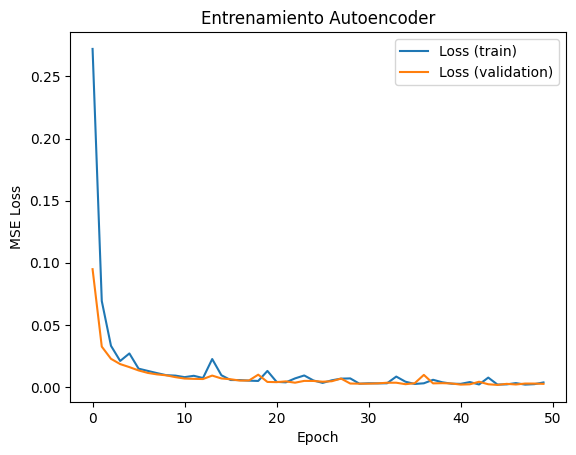

439/439 [==============================] - 0s 554us/step
INFO:tensorflow:Assets written to: models/team_encoder/assets


INFO:tensorflow:Assets written to: models/team_encoder/assets


In [48]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Copia del dataframe original
df = df_team_season_features.copy()

# Extraer columnas numéricas automáticamente (excluyendo id y categóricas)
non_num_cols = ['club_id', 'season']
num_cols = df.select_dtypes(include=[np.number]).columns.difference(non_num_cols).tolist()

print(f"Columnas numéricas usadas para el autoencoder: {num_cols}")

# Rellenar NA y extraer matriz numpy
X_num = df[num_cols].fillna(0).values.astype('float32')

# Normalizar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_num)

# Dividir en entrenamiento y validación (10%)
X_train, X_val = train_test_split(X_scaled, test_size=0.1, random_state=42)

# Parámetros del autoencoder
input_dim = X_scaled.shape[1]
emb_dim = 16

# Construcción del autoencoder
inp = Input(shape=(input_dim,))
enc = Dense(64, activation='relu')(inp)
enc = Dense(32, activation='relu')(enc)
embed = Dense(emb_dim, activation='linear', name='team_embedding')(enc)
dec = Dense(32, activation='relu')(embed)
dec = Dense(64, activation='relu')(dec)
out = Dense(input_dim, activation='linear')(dec)

auto = Model(inputs=inp, outputs=out)
auto.compile(optimizer=Adam(1e-3), loss='mse')

# Entrenamiento con validación
history = auto.fit(
    X_train, X_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, X_val),
    verbose=2
)

# Mostrar métricas de entrenamiento y validación
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Loss (train)')
plt.plot(history.history['val_loss'], label='Loss (validation)')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.title('Entrenamiento Autoencoder')
plt.show()

# Extraer embeddings del encoder
encoder = Model(inputs=inp, outputs=embed)
emb_matrix = encoder.predict(X_scaled)

# Añadir embeddings al dataframe original (solo columnas numéricas)
club_season_cols = df[['club_id', 'season']].reset_index(drop=True)
emb_cols = [f'team_emb_{i}' for i in range(emb_dim)]
df_emb = pd.DataFrame(emb_matrix, columns=emb_cols)

df_final = pd.concat([club_season_cols, df_emb], axis=1)
df_final = df_final.groupby(['club_id', 'season']).mean().reset_index()

# Guardar modelo y embeddings
auto.save('models/team_encoder', save_format='tf')
df_final.to_csv('embeddings/team_season_embedding.csv', index=False)


Es una buena aproximación inicial. Se analizará más en detalle su efectividad cuando se entrene el modelo poisson

# Jugadores

Haremos embeddings de los jugadores por temporadas. los datos que recogeremos son:
<li>played_minutes</li>
<li>played_matches</li>
<li>average_minutes_played_per_match</li>
<li>goals</li>
<li>assists</li>
<li>average_goals</li>
<li>average_assists</li>
<li>team_embedding</li>
<li>has_played_international</li>
<li>position</li>
<li>position_group</li>

In [49]:
df_appearances.head(1)

,appearance_id,game_id,player_id,player_club_id,player_current_club_id,date,player_name,competition_id,yellow_cards,red_cards,goals,assists,minutes_played
0,2231978_38004,2231978,38004,853,235,2012-07-03,Aurélien Joachim,CLQ,0,0,2,0,90


In [50]:
# Seleccionar columnas relevantes de df_games
games_info = df_games[['game_id', 'season', 'competition_type', 'home_club_id', 'away_club_id', 'home_club_goals', 'away_club_goals']].copy()

df_appearances = df_appearances.merge(
    games_info,
    on='game_id',
    how='left'
)

df_players = pd.read_csv('../Data/players.csv')

# Hacer merge para añadir la posición a df_appearances
df_appearances = df_appearances.merge(
    df_players[['player_id', 'sub_position']],
    on=['player_id'],
    how='left'
)

df_appearances.rename(columns={'sub_position': 'group_position'}, inplace=True)


# 3. Determinar goles propios y del oponente
def get_team_goals(row):
    if row['player_club_id'] == row['home_club_id']:
        return row['home_club_goals'], row['away_club_goals']
    elif row['player_club_id'] == row['away_club_id']:
        return row['away_club_goals'], row['home_club_goals']
    else:
        return None, None

df_appearances[['own_team_goals', 'opponent_team_goals']] = df_appearances.apply(
    get_team_goals, axis=1, result_type='expand'
)

df_appearances['is_win'] = df_appearances['own_team_goals'] > df_appearances['opponent_team_goals']
df_appearances['is_tie'] = df_appearances['own_team_goals'] == df_appearances['opponent_team_goals']


In [51]:
import pandas as pd
import numpy as np

dfa = df_appearances.copy()

# Rellena posibles valores nulos
dfa['minutes_played'] = dfa['minutes_played'].fillna(0)

# Valor de has_played_international si algun partido es international_cup
dfa['has_played_international'] = np.where(
    dfa['competition_type'] == 'international_cup', 1, 0
)

# Métricas del jugador por temporada
df_player_season_features = dfa.groupby(['season', 'player_id']).agg(
    played_minutes      = ('minutes_played', 'sum'),
    played_matches      = ('game_id',      'nunique'),
    goals               = ('goals',        'sum'),
    assists             = ('assists',      'sum'),
    own_team_goals_sum  = ('own_team_goals',      'sum'),
    opp_team_goals_sum  = ('opponent_team_goals', 'sum'),
    has_played_international = ('has_played_international', 'max'),  # 1 si jugó al menos una internacional
    group_position      = ('group_position', 'first')
).reset_index()

# Métricas derivadas
df_player_season_features['average_minutes_played_per_match'] = (
    df_player_season_features['played_minutes'] / df_player_season_features['played_matches'].replace(0, np.nan)
)

df_player_season_features['average_goals']   = df_player_season_features['goals']   / df_player_season_features['played_matches'].replace(0, np.nan)
df_player_season_features['average_assists'] = df_player_season_features['assists'] / df_player_season_features['played_matches'].replace(0, np.nan)

# Impacto ofensivo por 90'  (goles + asistencias normalizados a 90 min)
df_player_season_features['offensive_impact'] = (
    (df_player_season_features['goals'] + df_player_season_features['assists']) * 90 / df_player_season_features['played_minutes'].replace(0, np.nan)
)

# mpacto defensivo (versión simple). Número de goles EN CONTRA cuando el jugador jugó (ponderados por minutos)
df_player_season_features['defensive_impact'] = (
    df_player_season_features['opp_team_goals_sum'] * 90 / df_player_season_features['played_minutes'].replace(0, np.nan)
)


# Renombrar equipo del jugador
df_player_season_features = df_player_season_features.rename(columns={
    'player_club_id': 'team'
})


In [52]:
df_player_season_features.head()

,season,player_id,played_minutes,played_matches,goals,assists,own_team_goals_sum,opp_team_goals_sum,has_played_international,group_position,average_minutes_played_per_match,average_goals,average_assists,offensive_impact,defensive_impact
0,2012,10,4379,36,29,6,104,51,1,Centre-Forward,121.638889,0.805556,0.166667,0.719342,1.048185
1,2012,26,4401,49,0,0,109,56,1,Goalkeeper,89.816327,0.000000,0.000000,0.000000,1.145194
2,2012,65,3029,35,15,4,42,57,0,Centre-Forward,86.542857,0.428571,0.114286,0.564543,1.693628
3,2012,77,307,4,0,0,11,3,1,Centre-Back,76.750000,0.000000,0.000000,0.000000,0.879479
4,2012,80,360,4,0,0,10,0,0,Goalkeeper,90.000000,0.000000,0.000000,0.000000,0.000000


In [53]:
import pandas as pd

# Obtener el equipo en el que más jugó cada jugador en cada temporada
main_team_df = (
    dfa.groupby(['player_id', 'season', 'player_club_id'])['minutes_played']
    .sum()
    .reset_index()
    .sort_values(['player_id', 'season', 'minutes_played'], ascending=[True, True, False])
    .drop_duplicates(subset=['player_id', 'season'])
    .rename(columns={'player_club_id': 'main_team_id'})
    [['player_id', 'season', 'main_team_id']]
)

df_player_season_features = df_player_season_features.merge(
    main_team_df, on=['player_id', 'season'], how='left'
)

# 2. Cargar embeddings de equipos
team_embeddings = pd.read_csv('embeddings/team_season_embedding.csv')

# 3. Seleccionar solo las columnas necesarias: club_id, season y las últimas 16 columnas (embedding)
embedding_columns = ['club_id', 'season'] + list(team_embeddings.columns[-16:])
team_embeddings = team_embeddings[embedding_columns]
team_embeddings = team_embeddings.rename(columns={'club_id': 'main_team_id'})

# 4. Unir embeddings con main_team_df
main_team_embeddings = main_team_df.merge(team_embeddings, on=['main_team_id', 'season'], how='left')

# 5. Unir los embeddings con df_player_season_features
df_player_season_features = df_player_season_features.merge(main_team_embeddings, on=['player_id', 'season'], how='left')


In [54]:
df_player_season_features.columns

Index(['season', 'player_id', 'played_minutes', 'played_matches', 'goals',
       'assists', 'own_team_goals_sum', 'opp_team_goals_sum',
       'has_played_international', 'group_position',
       'average_minutes_played_per_match', 'average_goals', 'average_assists',
       'offensive_impact', 'defensive_impact', 'main_team_id_x',
       'main_team_id_y', 'team_emb_0', 'team_emb_1', 'team_emb_2',
       'team_emb_3', 'team_emb_4', 'team_emb_5', 'team_emb_6', 'team_emb_7',
       'team_emb_8', 'team_emb_9', 'team_emb_10', 'team_emb_11', 'team_emb_12',
       'team_emb_13', 'team_emb_14', 'team_emb_15'],
      dtype='object')

In [55]:
df_player_season_features.head()

,season,player_id,played_minutes,played_matches,goals,assists,own_team_goals_sum,opp_team_goals_sum,has_played_international,group_position,...,team_emb_6,team_emb_7,team_emb_8,team_emb_9,team_emb_10,team_emb_11,team_emb_12,team_emb_13,team_emb_14,team_emb_15
0,2012,10,4379,36,29,6,104,51,1,Centre-Forward,...,4.162858,-1.921434,-8.883998,4.898193,5.658831,0.566448,-1.978249,8.317524,-4.470030,10.057315
1,2012,26,4401,49,0,0,109,56,1,Goalkeeper,...,1.569812,-1.120473,-3.204886,0.996511,-1.205998,0.887887,1.757008,4.521529,-3.517565,3.168919
2,2012,65,3029,35,15,4,42,57,0,Centre-Forward,...,-0.782260,0.507897,-3.252824,0.948581,0.833633,0.358490,3.403290,1.141517,-1.476362,2.218311
3,2012,77,307,4,0,0,11,3,1,Centre-Back,...,1.086612,-0.176948,-3.667024,1.281946,-1.012317,1.179217,2.655585,4.493345,-4.164193,3.657577
4,2012,80,360,4,0,0,10,0,0,Goalkeeper,...,2.407882,-1.826893,-4.392081,2.324835,0.265306,0.166311,-0.104894,6.236982,-3.622871,5.003356


## Embedding de jugadores

In [56]:
df_player_season_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86911 entries, 0 to 86910
Data columns (total 33 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   season                            86911 non-null  int64  
 1   player_id                         86911 non-null  int64  
 2   played_minutes                    86911 non-null  int64  
 3   played_matches                    86911 non-null  int64  
 4   goals                             86911 non-null  int64  
 5   assists                           86911 non-null  int64  
 6   own_team_goals_sum                86911 non-null  int64  
 7   opp_team_goals_sum                86911 non-null  int64  
 8   has_played_international          86911 non-null  int64  
 9   group_position                    86911 non-null  object 
 10  average_minutes_played_per_match  86911 non-null  float64
 11  average_goals                     86911 non-null  float64
 12  aver

In [57]:
#df_player_season_features = df_player_season_features.dropna(subset=['team_emb_0','team_emb_1','team_emb_2','team_emb_3','team_emb_4','team_emb_5','team_emb_6','team_emb_7','team_emb_8','team_emb_9','team_emb_10','team_emb_11','team_emb_12','team_emb_13','team_emb_14','team_emb_15'])

Epoch 1/50
1223/1223 - 3s - loss: 0.3377 - mae: 0.3752 - val_loss: 0.1236 - val_mae: 0.1944 - lr: 0.0010 - 3s/epoch - 2ms/step
Epoch 2/50
1223/1223 - 2s - loss: 0.1609 - mae: 0.2531 - val_loss: 0.1043 - val_mae: 0.1730 - lr: 0.0010 - 2s/epoch - 2ms/step
Epoch 3/50
1223/1223 - 2s - loss: 0.1450 - mae: 0.2400 - val_loss: 0.0969 - val_mae: 0.1622 - lr: 0.0010 - 2s/epoch - 2ms/step
Epoch 4/50
1223/1223 - 2s - loss: 0.1362 - mae: 0.2328 - val_loss: 0.0827 - val_mae: 0.1574 - lr: 0.0010 - 2s/epoch - 2ms/step
Epoch 5/50
1223/1223 - 2s - loss: 0.1307 - mae: 0.2285 - val_loss: 0.0736 - val_mae: 0.1463 - lr: 0.0010 - 2s/epoch - 2ms/step
Epoch 6/50
1223/1223 - 2s - loss: 0.1269 - mae: 0.2246 - val_loss: 0.0701 - val_mae: 0.1486 - lr: 0.0010 - 2s/epoch - 2ms/step
Epoch 7/50
1223/1223 - 2s - loss: 0.1234 - mae: 0.2227 - val_loss: 0.0702 - val_mae: 0.1417 - lr: 0.0010 - 2s/epoch - 2ms/step
Epoch 8/50
1223/1223 - 2s - loss: 0.1212 - mae: 0.2197 - val_loss: 0.0711 - val_mae: 0.1424 - lr: 0.0010 - 2s/e

INFO:tensorflow:Assets written to: models/players/assets


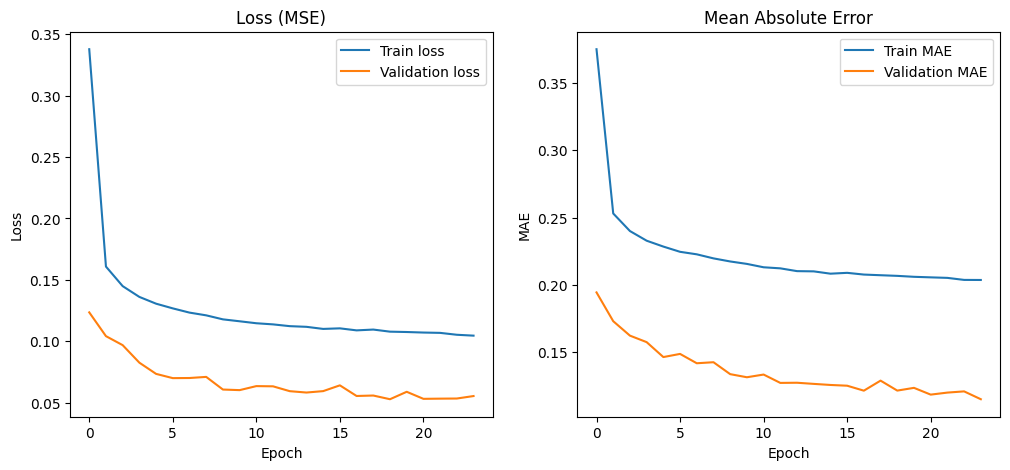

In [58]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Variables de entrada
df = df_player_season_features.copy()

id_cols = ['player_id', 'season']  # No se usan en el autoencoder
cat_cols = ['group_position']       # Variable categórica
num_cols = df.columns.difference(id_cols + cat_cols).tolist()

# Preprocesamiento (one‑hot para categóricas, estándar para numéricas)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), cat_cols)
    ],
    remainder='drop'
)

X_prepared = preprocessor.fit_transform(df)

input_dim = X_prepared.shape[1]
emb_dim = 16 # Reduce a la mitad las dimensiones originales

# Autoencoder con regularización
inp = Input(shape=(input_dim,))

enc = Dense(128, activation='relu')(inp)
enc = BatchNormalization()(enc)
enc = Dropout(0.2)(enc)
enc = Dense(64, activation='relu')(enc)
enc = BatchNormalization()(enc)
enc = Dropout(0.1)(enc)
emb = Dense(emb_dim, activation='linear', name='player_embedding')(enc)
dec = Dense(64, activation='relu')(emb)
dec = BatchNormalization()(dec)
dec = Dropout(0.1)(dec)
dec = Dense(128, activation='relu')(dec)
dec = BatchNormalization()(dec)
dec = Dropout(0.2)(dec)
out = Dense(input_dim, activation='linear')(dec)

auto = Model(inputs=inp, outputs=out)
auto.compile(optimizer=Adam(1e-3), loss='mse', metrics=['mae'])

# Callbacks para evitar overfitting y ajustar learning rate
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)

# Entrenamiento con validación y callbacks
history = auto.fit(
    X_prepared, X_prepared,
    epochs=50,
    batch_size=64,
    validation_split=0.1,
    callbacks=[early_stopping, reduce_lr],
    verbose=2
)

encoder = Model(inputs=inp, outputs=emb)
emb_matrix = encoder.predict(X_prepared)

# Concatenar embeddings al DataFrame original
emb_cols = [f'player_emb_{i}' for i in range(emb_dim)]
df_emb = pd.DataFrame(emb_matrix, columns=emb_cols)

df_final = pd.concat([df.reset_index(drop=True), df_emb], axis=1)

df_final.to_csv('embeddings/player_season_embedding.csv', index=False)
auto.save('models/players', save_format='tf')


# Graficar función de pérdida

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Mean Absolute Error')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.show()


# Modelo poisson mixto

In [59]:
df_games_poisson = df_games.copy()

In [60]:
df_games_poisson.columns

Index(['game_id', 'competition_id', 'season', 'round', 'date', 'home_club_id',
       'away_club_id', 'home_club_goals', 'away_club_goals',
       'home_club_position', 'away_club_position', 'home_club_manager_name',
       'away_club_manager_name', 'stadium', 'attendance', 'referee',
       'home_club_formation', 'away_club_formation', 'competition_type',
       'round_suffix', 'round_type', 'competition_phase', 'home_country_id',
       'away_country_id'],
      dtype='object')

In [61]:
def impute_embeddings_with_latest(df_embeddings, id_col, season_col='season'):
    df_embeddings = df_embeddings.sort_values([id_col, season_col])
    df_embeddings_imputed = (
        df_embeddings
        .set_index([id_col, season_col])
        .groupby(level=0)
        .ffill()
        .reset_index()
    )
    return df_embeddings_imputed

In [62]:
team_embeddings = pd.read_csv('embeddings/team_season_embedding.csv')

team_embeddings = (
    team_embeddings
    .drop_duplicates(subset=['club_id', 'season'])  # O usar .groupby y mean()
)


#team_embeddings = impute_embeddings_with_latest(team_embeddings, 'club_id', 'season')

# 1. Renombra club_id en team_embeddings para mergear como home y away
team_emb_cols = team_embeddings.columns[-16:]  # Últimas 15 columnas
team_emb_home = team_embeddings.rename(columns={'club_id': 'home_club_id'})
team_emb_away = team_embeddings.rename(columns={'club_id': 'away_club_id'})

# 2. Merge de embeddings de equipo (home y away)
df_games_poisson = df_games_poisson.merge(team_emb_home, on=['home_club_id', 'season'], how='left', suffixes=('', '_home'))
df_games_poisson = df_games_poisson.merge(team_emb_away, on=['away_club_id', 'season'], how='left', suffixes=('', '_away'))

In [63]:
df_games_poisson.head()

,game_id,competition_id,season,round,date,home_club_id,away_club_id,home_club_goals,away_club_goals,home_club_position,...,team_emb_6_away,team_emb_7_away,team_emb_8_away,team_emb_9_away,team_emb_10_away,team_emb_11_away,team_emb_12_away,team_emb_13_away,team_emb_14_away,team_emb_15_away
0,2321027,L1,2013,1. matchday,2013-08-11,33,41,3,3,8,...,0.967982,1.479220,-0.957088,1.242969,0.281150,-0.054128,0.771688,0.990104,-2.522868,1.387063
1,2321033,L1,2013,1. matchday,2013-08-10,23,86,0,1,13,...,0.621947,0.241732,-1.011527,0.645003,0.358575,0.622622,0.891391,1.069572,-2.124694,1.180548
2,2321044,L1,2013,2. matchday,2013-08-18,16,23,2,1,1,...,1.039852,1.510829,-0.958790,0.825460,0.353876,0.015186,0.900896,0.600934,-2.471880,1.380465
3,2321060,L1,2013,3. matchday,2013-08-25,23,24,0,2,18,...,3.404389,-0.987477,-4.782898,2.993668,4.084575,-0.898573,-2.350979,3.580742,-2.414836,5.757011
4,2321072,L1,2013,5. matchday,2013-09-14,16,41,6,2,1,...,0.967982,1.479220,-0.957088,1.242969,0.281150,-0.054128,0.771688,0.990104,-2.522868,1.387063


In [64]:
df_games_poisson.columns

Index(['game_id', 'competition_id', 'season', 'round', 'date', 'home_club_id',
       'away_club_id', 'home_club_goals', 'away_club_goals',
       'home_club_position', 'away_club_position', 'home_club_manager_name',
       'away_club_manager_name', 'stadium', 'attendance', 'referee',
       'home_club_formation', 'away_club_formation', 'competition_type',
       'round_suffix', 'round_type', 'competition_phase', 'home_country_id',
       'away_country_id', 'team_emb_0', 'team_emb_1', 'team_emb_2',
       'team_emb_3', 'team_emb_4', 'team_emb_5', 'team_emb_6', 'team_emb_7',
       'team_emb_8', 'team_emb_9', 'team_emb_10', 'team_emb_11', 'team_emb_12',
       'team_emb_13', 'team_emb_14', 'team_emb_15', 'team_emb_0_away',
       'team_emb_1_away', 'team_emb_2_away', 'team_emb_3_away',
       'team_emb_4_away', 'team_emb_5_away', 'team_emb_6_away',
       'team_emb_7_away', 'team_emb_8_away', 'team_emb_9_away',
       'team_emb_10_away', 'team_emb_11_away', 'team_emb_12_away',
       't

In [65]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import statsmodels.api as sm

df_train = df_games_poisson.drop(['game_id', 'competition_id', 'season', 'round', 'date', 'home_club_id', 'away_club_id',
                       'home_club_manager_name', 'away_club_manager_name', 'stadium', 'referee', 'home_club_formation', 'away_club_formation',
                       'home_country_id', 'away_country_id'
                       ], axis='columns')


# Tratamiento de valores nulos
df_train['home_club_position'] = pd.to_numeric(df_train['home_club_position'], errors='coerce')
df_train['away_club_position'] = pd.to_numeric(df_train['away_club_position'], errors='coerce')

df_train['home_club_position'].fillna(df_train['home_club_position'].median(), inplace=True)
df_train['away_club_position'].fillna(df_train['away_club_position'].median(), inplace=True)

df_train['competition_phase_missing'] = df_train['competition_phase'].isna().astype(int)
df_train['competition_phase'].fillna(df_train['competition_phase'].median(), inplace=True)


# 2. Separar numéricas y categóricas
categorical_cols = ['competition_type', 'round_type', 'round_suffix']
numerical_cols = list(set(df_train.columns) - set(categorical_cols))

# 3. Preprocesamiento
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(drop='first'), categorical_cols)
])

# X: variables predictoras
X = df_train[df_train.columns].copy()

# y: variable objetivo (home_goals, pero podrías hacer lo mismo para away_goals)
y = df_train['home_club_goals']

# Transformar los datos
X_processed = preprocessor.fit_transform(X)

# 4. Agregar constante para statsmodels
X_processed = sm.add_constant(X_processed)

# 5. Entrenar modelo Poisson
poisson_model = sm.GLM(y, X_processed, family=sm.families.Poisson())
poisson_results = poisson_model.fit()

print(poisson_results.summary())

/tmp/ipykernel_552000/3232452285.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train['home_club_position'].fillna(df_train['home_club_position'].median(), inplace=True)
/tmp/ipykernel_552000/3232452285.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when

                 Generalized Linear Model Regression Results                  
Dep. Variable:        home_club_goals   No. Observations:                78488
Model:                            GLM   Df Residuals:                    78422
Model Family:                 Poisson   Df Model:                           65
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -92141.
Date:                Mon, 16 Jun 2025   Deviance:                       32703.
Time:                        06:58:04   Pearson chi2:                 2.11e+04
No. Iterations:                   100   Pseudo R-squ. (CS):             0.6179
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2621      0.055      4.729      0.0

In [67]:
import numpy as np

# Columnas categóricas después del one-hot encoding
ohe = preprocessor.named_transformers_['cat']
ohe_cols = ohe.get_feature_names_out(categorical_cols)

# Todas las columnas en el orden en que entraron al modelo
all_columns = np.concatenate([numerical_cols, ohe_cols])

import pandas as pd

coefficients = poisson_results.params


coef_table = pd.DataFrame({
    'variable': all_columns,
    'coef': coefficients[1:],  # Saltamos 'const'
})

coef_table = pd.DataFrame({
    'variable': poisson_results.params.index,
    'coefficient': poisson_results.params.values
})
coef_table.index = range(1, len(coef_table) + 1)

feature_names = preprocessor.get_feature_names_out()


coef_table = pd.DataFrame({
    'variable': feature_names,
    'coefficient': poisson_results.params[1:]  # saltamos const
})



<Axes: >

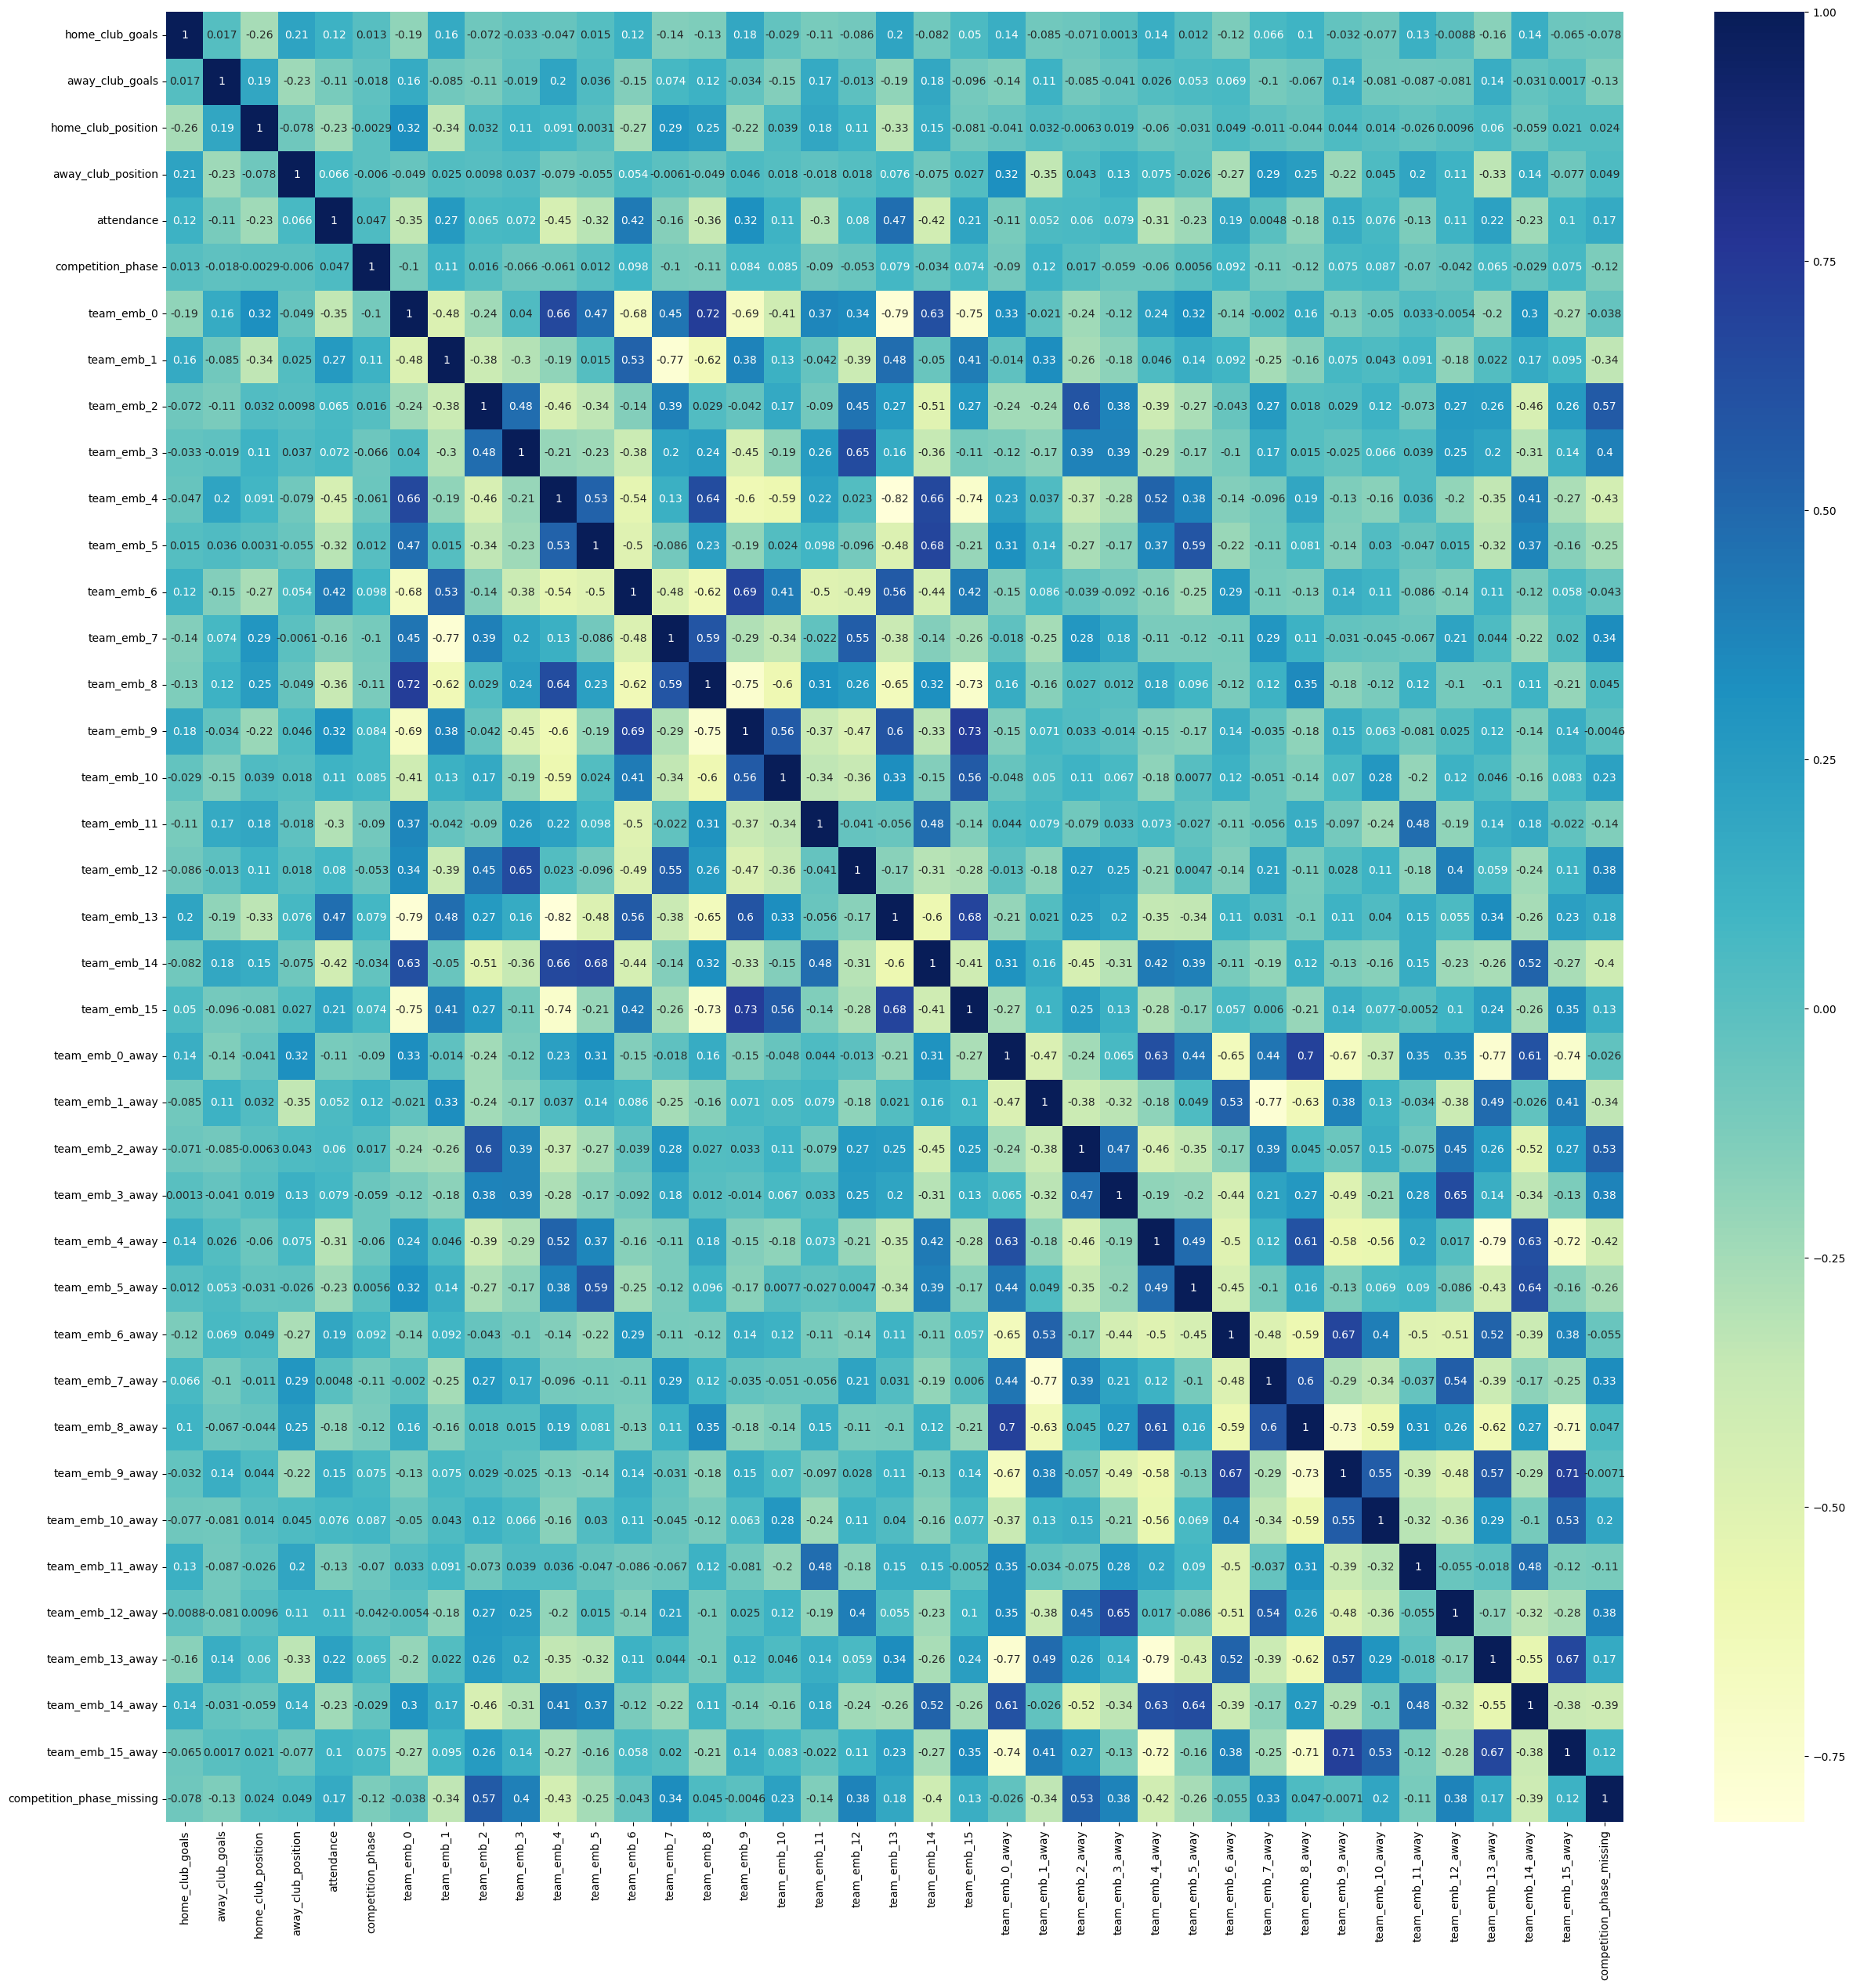

In [69]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(30,30))
sns.heatmap(df_train.corr(numeric_only=True), cmap="YlGnBu", annot=True)

# Conclusión

En este notebook se ha demostrado cómo combinar técnicas de *feature engineering* avanzadas, como la generación de embeddings mediante autoencoders, con modelos estadísticos clásicos, en este caso un modelo de regresión Poisson, para analizar y extraer información relevante en el contexto del análisis de partidos de fútbol.

Aunque el modelo Poisson es capaz de predecir resultados de partidos basándose en las variables y embeddings generados, el enfoque principal aquí ha sido interpretar las métricas y relaciones entre variables para obtener insights útiles. Por ejemplo, se confirma que la posición en el ranking de un equipo influye significativamente en sus probabilidades de victoria, lo cual es consistente con la intuición y evidencia empírica previa.

Además, el análisis sugiere que factores externos, como la presencia del público, pueden tener un impacto positivo en el rendimiento del equipo local, destacando la importancia de considerar variables contextuales que van más allá de las estadísticas puras del equipo y jugadores.


Finalmente, este pipeline de análisis y generación de características puede ser reutilizado y adaptado para otros deportes o problemas similares donde la combinación de datos estructurados y representaciones latentes puede aportar valor.